<a href="https://colab.research.google.com/github/wcl20/Imperial-460/blob/master/CW1/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Initialise weight
        HH, WW = kernel_size
        self.w = nn.Parameter(torch.empty(out_channels, in_channels, HH, WW))
        nn.init.kaiming_normal_(self.w, mode='fan_out', nonlinearity='relu')
        # Initialise bias
        if bias:
            #self.b = torch.zeros(out_channels,)
            self.b = nn.Parameter(torch.zeros(out_channels, ))
        # Initiliase parameters
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        N, C, H, W = x.size()
        HH, WW = self.kernel_size
        # Compute output size
        out_H = int((H - HH + 2 * self.padding) / self.stride) + 1
        out_W = int((W - WW + 2 * self.padding) / self.stride) + 1 
        # Take input x
        out = x
        # Unfold x to shape (N, C*HH*WW, H'*W')
        out = F.unfold(out, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        # Perform convolution. Reshape w to shape (F, C*HH*WW). output shape (N, F, H'*W').
        out = self.w.view(self.out_channels, -1) @ out
        # Reshape output to shape (N, F, H', W')
        out = out.view(N, self.out_channels, out_H, out_W)
        # Add bias term.
        if self.bias:
            # Reshape bias term to shape (F, 1, 1)
            out = out + self.b.reshape(self.out_channels, 1, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.kernel_size = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.size()
        HH, WW = self.kernel_size
        # Compute output size
        out_H = int((H - HH) / HH) + 1
        out_W = int((W - WW) / WW) + 1
        # Take input x
        out = x
        # Unfold 3rd dimension (H) to shape (N, C, H', W, HH)
        out = out.unfold(2, HH, HH)
        # Unfold 4th dimension (W) to shape (N, C, H', W', HH, WW)
        out = out.unfold(3, WW, WW)
        # Reshape output to shape (N, C, H', W', HH*WW)
        out = out.reshape(N, C, out_H, out_W, -1)
        # Find max of the 5th dimension (kernel)
        out, _ = out.max(4)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Initialise weight
        self.w = nn.Parameter(torch.empty(in_channels, out_channels))
        nn.init.kaiming_normal_(self.w, mode='fan_out', nonlinearity='relu')
        # Initialise bias
        self.b = nn.Parameter(torch.zeros(out_channels,))
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Take input x
        out = x
        # Compute xw + b
        out = out @ self.w + self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Initiliase parameters
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features,))
        self.beta = nn.Parameter(torch.zeros(num_features,))
        # Moving statistics
        self.running_mean = torch.zeros(num_features,).reshape(1, num_features, 1, 1)
        self.running_var = torch.zeros(num_features,).reshape(1, num_features, 1, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        _, C, _, _ = x.size()
        # During training ...
        if self.training:
            # Compute mean for each channel
            mean = x.mean(dim=(0, 2, 3), keepdim=True)
            # Update running mean
            self.running_mean = self.running_mean * self.momentum + mean * (1 - self.momentum)
            # Compute variance for each channel
            variance = torch.mean((x - mean) ** 2, dim=(0, 2, 3), keepdim=True)
            # Update running variance
            self.running_var = self.running_var * self.momentum + variance * (1 - self.momentum)
        # During testing ...
        else:
            # Use running mean as mean
            mean = self.running_mean
            # Use running variance as variance
            variance = self.running_var
        # Normalize
        x = (x - mean) / (torch.sqrt(variance + self.eps))
        # Scale and shift
        x = self.gamma.reshape((1, C, 1, 1)) * x + self.beta.reshape((1, C, 1, 1)) 

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

Answer:

A common method to find hyperparameters for neural networks is through Trial and Error. This approach mannually experiment with different combinations of hyperparameter and find the one with the best performance. 

A more systematic approach is by using Grid Search. The user defines a set of values for each parameter and Grid Search tries all possible configuration to find the best one. This method is better than Trial and Error because it searches for the parameters automaticaly. One drawback of Grid Search is that it is time consuming if the search space is large.

A better strategy is to combine "Trial and Error" with "Grid Search". First use Trial and Error to estimate the best hyperparameters. Then define a search space around the best hyperparameters and use Grid Search to find the best combination.





In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))                     
])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [0]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, transform=transform_train, download=True)
cifar10_test = dset.CIFAR10(data_dir, train=False, transform=transform_test)
# Create dataloaders
loader_train = DataLoader(cifar10_train, batch_size=64, shuffle=True)
loader_test = DataLoader(cifar10_test, batch_size=64, shuffle=False)

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        # Return accuracy score
        return 100 * acc

        

def train_part(model, optimizer, verbose=True, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        # print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if verbose and t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                

In [0]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Hyperparameter space
lrs = [0.0001, 0.001, 0.01]

best_lr = None
best_accuracy = 0

for lr in lrs:
    print(f"Learning rate: {lr}.")
    # Define model 
    model = ResNet18()
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    # Train model
    train_part(model, optimizer, verbose=False, epochs=10)
    # Check test accuracy
    accuracy = check_accuracy(loader_test, model)
    # Update best hyperparameters
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_lr = lr
print()
print(f"Best learning rate: {best_lr}.")

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

Learning rate: 0.0001.
Checking accuracy on test set
Got 8492 / 10000 correct (84.92)
Learning rate: 0.001.
Checking accuracy on test set
Got 8228 / 10000 correct (82.28)
Learning rate: 0.01.
Checking accuracy on test set
Got 5797 / 10000 correct (57.97)

Best learning rate: 0.0001.


In [0]:
lr = 0.001

# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_part(model, optimizer, epochs = 10)

# report test set accuracy
check_accuracy(loader_test, model)

# save the model
torch.save(model.state_dict(), 'model.pt')

Epoch: 0, Iteration 0, loss = 2.7869
Epoch: 0, Iteration 100, loss = 1.7698
Epoch: 0, Iteration 200, loss = 1.6814
Epoch: 0, Iteration 300, loss = 1.7758
Epoch: 0, Iteration 400, loss = 1.4611
Epoch: 0, Iteration 500, loss = 1.3552
Epoch: 0, Iteration 600, loss = 1.3281
Epoch: 0, Iteration 700, loss = 1.3908
Epoch: 1, Iteration 0, loss = 1.2333
Epoch: 1, Iteration 100, loss = 1.2352
Epoch: 1, Iteration 200, loss = 1.1218
Epoch: 1, Iteration 300, loss = 0.9674
Epoch: 1, Iteration 400, loss = 1.0108
Epoch: 1, Iteration 500, loss = 0.9893
Epoch: 1, Iteration 600, loss = 1.0416
Epoch: 1, Iteration 700, loss = 0.8506
Epoch: 2, Iteration 0, loss = 0.9201
Epoch: 2, Iteration 100, loss = 0.9707
Epoch: 2, Iteration 200, loss = 0.6711
Epoch: 2, Iteration 300, loss = 1.0617
Epoch: 2, Iteration 400, loss = 0.8638
Epoch: 2, Iteration 500, loss = 0.5808
Epoch: 2, Iteration 600, loss = 0.8212
Epoch: 2, Iteration 700, loss = 0.6953
Epoch: 3, Iteration 0, loss = 0.6236
Epoch: 3, Iteration 100, loss = 0

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

Answer:

1. There are more feature maps at higher-level layers than lower-level layers. Furthermore, the feature maps at higher-levels learn more complex features than features maps at lower-levels.

  The test image is an image of a cat. The first layers (layer 1, 2) of the CNN detects low-level features such as edges, corners and curves. The middle layers (layer 3) use these low-level features to learn more abstract concepts and is able to classify parts of the cat such as ears and eyes. The last layer (layer 4) has the highest representations, it is able to recognize the whole cat in different postures and positions.

2. The classification model achieved an accuracy of 0.8553 on the test set. The performance is sufficiently good given the model is only trained in 10 epochs.

 From the training log, the training loss decreases to a point of stability. This indicates the model is not underfitting and has sufficient capacity for the complexity of the dataset. Furthermore, the final training loss remained at 0.3, which is large enough to suggest the model is not overfitting.

 The feature maps show that the model is indeed capturing useful features similar to traditional feature extraction methods. The lower layers are capturing low-level features such as edges and corners similar to sobel filters. The higher layers utilize features from previous layers to learn more abstract concepts.

 The accuracy can be further improved by minimising optimisation error. This can be achieved by training the model for longer period of time, i.e. training with more epochs.

3. Accurarcy measures the number of correctly classified samples over the total number of samples. Apart from accuracy, there are other metrics that can be used to describe the performance of a classification model such as Recall and Precision.

  Recall is the number of correctly classified positive examples divided by the total number of positive examples. A high recall means that most of the positive examples are correctly recognised. For multiclass classification, Unweighted Average Recall measures the mean recall for all classes.

  Precision is the number of correctly classified positive examples divided by the total number of predicted positive examples. A high precision means that if the model predicts a positive it is very likely to be positive. Similar to recall, precision can be calculated for each class.

  A good classification model should have high recall and high precision. The F1 Score is the weighted average of Recall and Precision, it is used to find the best model that balances between recall and precision. 
  
  A more detailed analysis is to build a confusion matrix for the classification model. The confusion matrix can be used to visualize the performance of the model on classifying each class. 


  

<Figure size 432x288 with 0 Axes>

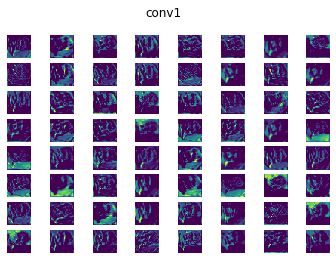

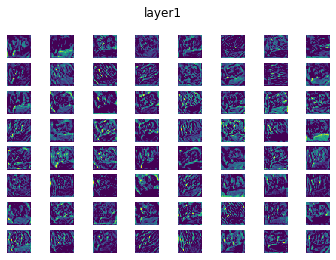

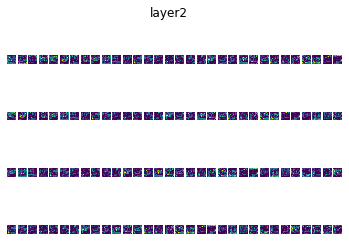

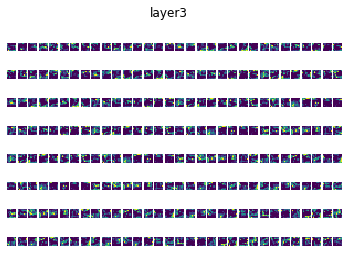

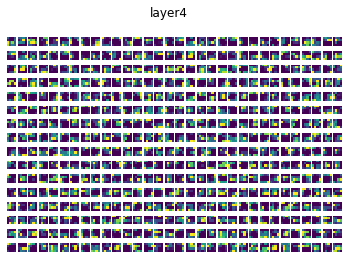

In [0]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)

for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')